# **GraphSAGE** 
Made for the task of Node Regression (node attribute prediction).

## Installation

In [ ]:
#LINUX
"""
!pip install torch==2.4.0
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src
!pip install torch-geometric
!pip install matplotlib
!pip install pandas
"""

In [ ]:
# run these commands in py-venv if on WINDOWS
"""
pip install pandas
pip install matplotlib
"""

# CPU:
"""
pip install torch==2.4.0
pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.4.0.html
pip install torch-geometric
"""

# GPU:
"""
pip install torch==2.8.0+cu126 --index-url https://download.pytorch.org/whl/cu126
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
pip install torch_geometric -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
"""

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

cuda
2.8.0+cu126
12.6
True


## GNN Stack Module

Below is the implementation of a general GNN stack where we plug in our GraphSAGE layer.

In [ ]:
import os
import torch_geometric
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

from torch.nn import Parameter, Linear
from torch_geometric.nn.conv import MessagePassing

class GNNStack(torch.nn.Module):
    def __init__(self, numeric_attr_dim, categories_list, encoder_out_emb_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()

        # instantiate the AttributeEncoder as part of the GNNStack
        self.attribute_encoder = AttributeEncoder(categories_list, out_emb_dim=encoder_out_emb_dim)
        input_dim = encoder_out_emb_dim # the output of the attribute encoder is the input to the GNN

        # Build GNN layers
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))

        for l in range(args.num_layers-1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers
        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage

    def forward(self, numeric_data, cat_data_list, categories_list, edge_index, batch):
        # First, generate node features 'x' using the AttributeEncoder
        x = self.attribute_encoder(numeric_data, cat_data_list, categories_list)

        # Then, pass 'x' through the GNN layers
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        if self.emb:
            return x

        x = self.post_mp(x)
        x = F.softplus(x)
        return x

    def loss(self, pred, label):
        loss = 0.5 * F.mse_loss(pred, label) + 0.5 * F.l1_loss(pred, label)
        return loss 

## GraphSAGE Implementation

In [3]:
class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True, bias = False, **kwargs):

        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = torch.nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = torch.nn.Linear(in_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):

        # Computes aggregated neighbor embeddings for 
        # each node and adds self-node contribution
        out = self.propagate(edge_index, x=(x,x))
        out = self.lin_l(x) + self.lin_r(out)
        if self.normalize: # optional normalization
          out = torch.nn.functional.normalize(out)

        return out

    # node attributes are sent to neighbors
    def message(self, x_j):
        out = x_j
        return out

    # mean aggregation of GraphSAGE
    def aggregate(self, inputs, index, dim_size = None):
        # inputs = messages(attributes) from neighbors
        # index = target node

        node_dim = self.node_dim # the axis along which to index number of nodes
        out = torch_scatter.scatter(inputs,index,node_dim,reduce="mean")

        return out

## Attribute Encoders

We use the CategoricalEncoder to put each categorical attribute through an MLP and create their embeddings. We concatenate them together with numerical attributes. Numerical attributes are passed as is.

In [4]:
class CategoricalEncoder(nn.Module):
    def __init__(self, size):
        # size = list of all category sizes
        super().__init__()

        # MLP
        self.embedders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(i, int(i/2)), 
                nn.ReLU(), 
                nn.Linear(int(i/2),int(i/2))
            )
            for i in size
        ])

    # pushes categorical attributes as one-hot encodings through an MLP    
    def forward(self, id_list, n_classes):
        emb_out = []
        for mlp, ids, categories in zip(self.embedders, id_list, n_classes):
            one_hot = F.one_hot(ids, num_classes=categories).float().to(device)
            emb = mlp(one_hot) # <-- [num_nodes, emb_dim]
            emb_out.append(emb)

        # concatenates them all together
        return torch.cat(emb_out, dim=1)
        
class AttributeEncoder(nn.Module):
    def __init__(self, size, out_emb_dim=None):
        # size = list of all category sizes
        # out_emb_dim = dimension of the output embedding (final MLP)

        super().__init__()

        self.category_encoder = CategoricalEncoder(size)

        total_dim = 0
        for i in size:
            total_dim += int(i/2)
        if out_emb_dim == None: # if no custom embedding is provided
            out_emb_dim = total_dim

    def forward(self, val_attr, cat_attr, n_classes):
        # calls the CategoricalEncoder
        cat_emb = self.category_encoder(cat_attr, n_classes)
        x = torch.cat([val_attr, cat_emb], dim=1)
        
        return x

## DB Conversion

We convert the DB to actual usable data, like nodes, attributes, edges...

In [5]:
import copy
import pandas as pd
import sqlite3 as sql
from torch_geometric.data import Data

db_directory = "../../datasets/forest_db.sqlite" # <<<--- CHANGE THIS TO THE DATASET YOU ARE USING!!!

# extracts relevant data from DB
db = sql.connect(db_directory)
nodes = pd.read_sql_query("SELECT id FROM nodes", db)
node_attr = pd.read_sql_query("SELECT * FROM sestoji_attr", db)
edges = pd.read_sql_query("SELECT n1_id, n2_id FROM edges", db)
regional_attr = pd.read_sql_query("SELECT * FROM odseki_attr", db)

#REGIONAL ATTRIBUTES:
# 'nagib', 'nvod', 'nvdo', 'kamnit', 'skalnat', 'katgozd', 'pozar', 
# 'intgosp', 'kamnina', 'relief', 'ohranjen', 'polpokr', 'lega'
# tarifa_XX - tree quality rank by tree type

#NODE ATTRIBUTES:
# 'povrsina_x', 'pompov',  'rfaza', 'sksmerni', 
# 'zasnova', 'sklep', 'pomzas', 'negovan', 'lzigl', 'lzlst'
# 'lzskdvXX' - tree composition ratio
# 'lzskdvXX_m' - sapling composition ratio

# REGIONAL ATTRIBUTES NOTES:
# 'ke','gge' cant be used, nums arent unique
# 'ggo','tarifa' worsens performance
#NOT USING: rgr_gge, rgr_ggo, 'grt1', 'rk', 'odprtost', 'carb_tot_t', 'ponor_c'

# access regional attributes
nodes_with_region = node_attr.merge(
    regional_attr,
    on=['ggo', 'odsek'],
    how='left'
)
#print(nodes_with_region.columns.tolist())

# map global node IDs to 0-based indices (only needed if using part of the dataset)
node_ids = nodes['id'].tolist()  # current subset
id_to_idx = {nid: i for i, nid in enumerate(node_ids)}

# filter edges by subset (only needed if using part of the dataset)
edges = edges[edges['n1_id'].isin(id_to_idx) & edges['n2_id'].isin(id_to_idx)].copy()
edges['n1_id'] = edges['n1_id'].map(id_to_idx)
edges['n2_id'] = edges['n2_id'].map(id_to_idx)
edge_index = torch.tensor(edges[['n1_id', 'n2_id']].values, dtype=torch.long).t().contiguous()

print(edge_index.shape)
print(edge_index.min(), edge_index.max())

# attributes with numeric values
val_cols = ['povrsina_x', 'pompov', 'lzigl', 'lzlst', 
            'lzskdv11', 'lzskdv21', 'lzskdv30', 'lzskdv34', 'lzskdv39', 'lzskdv41', 'lzskdv50', 'lzskdv60', 'lzskdv70', 'lzskdv80', 
            'lzskdv11_m','lzskdv21_m','lzskdv30_m','lzskdv34_m','lzskdv39_m','lzskdv41_m','lzskdv50_m','lzskdv60_m','lzskdv70_m','lzskdv80_m', 
            #'tarifa_sm', 'tarifa_je', 'tarifa_oi', 'tarifa_bu', 'tarifa_hr', 'tarifa_pl', 'tarifa_tl', 'tarifa_ml',
            'nagib', 'nvod', 'nvdo', 'kamnit', 'skalnat']

# forest composition (node attributes)
lzskdv_cols = [
    c for c in val_cols
    if c.startswith("lzskdv") and not c.endswith("_m")
]
lzskdv_m_cols = [
    c for c in val_cols
    if c.startswith("lzskdv") and c.endswith("_m")
]
tarifa_cols = [
    c for c in val_cols
    if c.startswith("tarifa")
]
rock_cols = [
    c for c in val_cols
    if c.startswith("kamnit") or c.startswith("skalnat")
]
# normalize to scale 0-1
nodes_with_region[lzskdv_cols] /= 100.0
nodes_with_region[lzskdv_m_cols] /= 100.0
nodes_with_region[tarifa_cols] /= 100.0
nodes_with_region[rock_cols] /= 100.0

value_attr = torch.tensor(nodes_with_region[val_cols].values, dtype=torch.float)

# categorical string attributes
cat_cols = ['rfaza', 'sksmerni', 'zasnova', 'sklep', 'negovan', 'pomzas', 'katgozd', 'pozar', 'intgosp', 'kamnina', 'relief', 'ohranjen', 'polpokr', 'lega']
for col in ['zasnova', 'sklep', 'negovan',]: # idk why, but some are still strings or floats?
    nodes_with_region[col] = nodes_with_region[col].astype(int) 
categorical_attr = [torch.tensor(nodes_with_region[i].values, dtype=torch.long) for i in cat_cols]
print(nodes_with_region[cat_cols].dtypes)

# prediction attributes
trg_cols = ['etigl', 'etlst']
target_attr = torch.tensor(node_attr[trg_cols].values, dtype=torch.float)

data = Data(x=None, numeric=value_attr, edge_index=edge_index, y=target_attr)
                        # number of categories per attribute:
data.rfaza = categorical_attr[0]     # (11)
data.sksmerni = categorical_attr[1]  # (21)
data.zasnova = categorical_attr[2]   # (5)
data.sklep = categorical_attr[3]     # (6)
data.negovan = categorical_attr[4]   # (5)
data.pomzas = categorical_attr[5]    # (5)
data.katgozd = categorical_attr[6]   # (4)
data.pozar = categorical_attr[7]     # (5)
data.intgosp = categorical_attr[8]   # (6)
data.kamnina = categorical_attr[9]   # (39)
data.relief = categorical_attr[10]   # (9)
data.ohranjen = categorical_attr[11] # (4)
data.polpokr = categorical_attr[12]  # (4)
data.lega = categorical_attr[13]     # (9)

categories = [11,21,5,6,5,5,4,5,6,39,9,4,4,9] # number of categories are determined by the data provided from the DB
numeric_attr = len(val_cols)
cat_list = [data.rfaza, data.sksmerni, data.zasnova, data.sklep, data.negovan, data.pomzas, data.katgozd, data.pozar, data.intgosp, data.kamnina, data.relief, data.ohranjen, data.polpokr, data.lega]


print(nodes_with_region.columns.tolist())
print(data)

torch.Size([2, 1877718])
tensor(0) tensor(347337)
rfaza       int64
sksmerni    int64
zasnova     int32
sklep       int32
negovan     int32
pomzas      int64
katgozd     int64
pozar       int64
intgosp     int64
kamnina     int64
relief      int64
ohranjen    int64
polpokr     int64
lega        int64
dtype: object
['id', 'node_id', 'GEOMETRY_x', 'ggo', 'ggo_naziv_x', 'odsek', 'sestoj', 'povrsina_x', 'rfaza', 'rfaza_naziv', 'lzskdv11', 'lzskdv11_m', 'lzskdv21', 'lzskdv21_m', 'lzskdv30', 'lzskdv30_m', 'lzskdv34', 'lzskdv34_m', 'lzskdv39', 'lzskdv39_m', 'lzskdv41', 'lzskdv41_m', 'lzskdv50', 'lzskdv50_m', 'lzskdv60', 'lzskdv60_m', 'lzskdv70', 'lzskdv70_m', 'lzskdv80', 'lzskdv80_m', 'sksmerni', 'sksmerni_naziv', 'zasnova', 'zasnova_naziv', 'sklep', 'sklep_naziv', 'negovan', 'negovanost_naziv', 'pompov', 'pomzas', 'pomzas_naziv', 'lzigl', 'lzlst', 'lzsku', 'etigl', 'etlst', 'etsku', 'ogc_fid', 'GEOMETRY_y', 'ggo_naziv_y', 'povrsina_y', 'gge', 'gge_naziv', 'ke', 'ke_naziv', 'revir', 'revir_na

### Datasplit
You can choose between a transductive split that randomly splits nodes. Or an inductive split by "revir" regions. The train/val/test ratio is customizable.

In [ ]:
# Train/val/test split
split_type = "random" # <---- split type
split = [0.8, 0.1, 0.1] # split must sum to 1

if split_type == "random":
    num_nodes = data.num_nodes
    perm = torch.randperm(num_nodes)
    train_idx = perm[:int(split[0]*num_nodes)]
    val_idx   = perm[int(split[0]*num_nodes):int((split[0]+split[1])*num_nodes)]
    test_idx  = perm[int((split[0]+split[1])*num_nodes):]


elif split_type == "revir":
    num_nodes = data.num_nodes
    nodes_with_revir = node_attr[['ggo', 'odsek']].merge(
        regional_attr[['ggo', 'odsek', 'revir']],
        on=['ggo', 'odsek'],
        how='left'
    )

    node_revirs = nodes_with_revir['revir'].values

    unique_revirs = [r for r in set(node_revirs) if r is not None]
    num_revirs = len(unique_revirs)

    perm = torch.randperm(num_revirs)

    train_revirs = set([unique_revirs[i] for i in perm[:int(split[0]*num_revirs)]])
    val_revirs   = set([unique_revirs[i] for i in perm[int(split[0]*num_revirs):int((split[0]+split[1])*num_revirs)]])
    test_revirs  = set([unique_revirs[i] for i in perm[int((split[0]+split[1])*num_revirs):]])

    train_mask = torch.tensor([r in train_revirs for r in node_revirs], dtype=torch.bool)
    val_mask   = torch.tensor([r in val_revirs for r in node_revirs], dtype=torch.bool)
    test_mask  = torch.tensor([r in test_revirs for r in node_revirs], dtype=torch.bool)

    train_idx = torch.nonzero(train_mask, as_tuple=False).view(-1)
    val_idx   = torch.nonzero(val_mask, as_tuple=False).view(-1)
    test_idx  = torch.nonzero(test_mask, as_tuple=False).view(-1)

    # Remove edges between splits

    #node_split_id = torch.full((data.num_nodes,), -1, dtype=torch.long)
    node_split_id = torch.full((data.num_nodes,), -1, dtype=torch.long, device=data.edge_index.device)
    node_split_id[train_idx] = 0
    node_split_id[val_idx]   = 1
    node_split_id[test_idx]  = 2
    
    # Get source and target nodes of all edges
    row, col = data.edge_index
    
    # Check which split the source and target belong to
    split_src = node_split_id[row]
    split_dst = node_split_id[col]
    
    # Keep edge ONLY if source and target are in the same split (0==0, 1==1, 2==2)
    # AND the node was actually assigned a split (split_id != -1)
    edge_mask = (split_src == split_dst) & (split_src != -1)
    
    original_edge_count = data.edge_index.size(1)
    data.edge_index = data.edge_index[:, edge_mask]
    new_edge_count = data.edge_index.size(1)
    
    print(f"Edges Pruned: {original_edge_count} -> {new_edge_count}")
    print(f"Removed {original_edge_count - new_edge_count} edges crossing between revirs.")
else:
    print("Invalid selection")


mean_train_targets = data.y[train_idx].mean().item()
mean_val_targets = data.y[val_idx].mean().item()
mean_test_targets = data.y[test_idx].mean().item()

print(f"Train Nodes: {len(train_idx)/num_nodes} | Val Nodes: {len(val_idx)/num_nodes} | Test Nodes: {len(test_idx)/num_nodes}")

Print out for "revir" DB split type.

In [34]:
print("data.num_nodes =", getattr(data, "num_nodes", None),
      "| len(node_attr) =", len(node_attr),
      "| len(regional_attr) =", len(regional_attr))

dups = regional_attr[regional_attr.duplicated(subset=["ggo", "odsek"], keep=False)]
if not dups.empty:
    print(f"WARNING: regional_attr has {dups['ggo'].nunique()} duplicated (ggo,odsek) keys (total rows: {len(dups)}).")
    display(dups.sort_values(["ggo","odsek"]).head(10))

regional_unique = regional_attr.drop_duplicates(subset=["ggo", "odsek"], keep="first").copy()

nodes_with_revir = node_attr[["ggo", "odsek"]].merge(
    regional_unique[["ggo", "odsek", "revir", "revir_naziv"]],
    on=["ggo", "odsek"],
    how="left"
).reset_index(drop=True)

revir_name_map = (
    regional_attr[["ggo", "revir", "revir_naziv"]]
    .drop_duplicates(subset=["ggo","revir"])
    .copy()
)
revir_name_map["revir_naziv"] = (
    revir_name_map["revir_naziv"].astype(str).str.lower().str.title()
)

total_revirs = len(set(zip(nodes_with_revir["ggo"], nodes_with_revir["revir"])))
total_nodes  = len(nodes_with_revir)

for split in ["train","val","test"]:
    idx_list = train_idx if split=="train" else val_idx if split=="val" else test_idx
    sub_nodes = nodes_with_revir.iloc[idx_list]

    nodes_per_revir = (
        sub_nodes.groupby(["ggo","revir"])
        .size()
        .reset_index(name="Nodes")
    )


    sub_df = nodes_per_revir.merge(revir_name_map, on=["ggo","revir"], how="left")
    sub_df = sub_df.sort_values("revir_naziv").reset_index(drop=True)

    n_revirs = len(sub_df)
    n_nodes  = sub_df["Nodes"].sum()
    perc_revirs = 100 * n_revirs / total_revirs
    perc_nodes  = 100 * n_nodes / total_nodes

    print(f"-----------[{split.upper()}] Revirs: {n_revirs} ({perc_revirs:.1f}%) | Nodes: {n_nodes} ({perc_nodes:.1f}%) -----------")
    print(sub_df[["ggo","revir","revir_naziv","Nodes"]].to_string(index=False))
    print()


data.num_nodes = 347338 | len(node_attr) = 347338 | len(regional_attr) = 53410
-----------[TRAIN] Revirs: 396 (100.0%) | Nodes: 277870 (80.0%) -----------
 ggo  revir         revir_naziv  Nodes
   7   2680            Adlešiči    943
   7   2455             Ajdovec    769
   1   2505          Ajdovščina    331
   7   2459              Ambrus    664
  11   2405               Anton    442
  13   2134               Apače   1061
  12   3223                Areh    794
   5   2108                Baba    680
   3   2523             Barbara    823
   2   2423    Begunje - Ljubno    890
  10   2316           Bele Vode    434
   4   2778              Bistra    602
  11   2504      Bistra - Topla    468
   3   2316              Bitnje    577
  12   3344                 Biš    864
   4   2142           Blagovica    680
   2   2212                Bled    804
   5   2434               Bloke   1048
   2   2413      Bohinjska Bela    845
   8   2130               Bohor    517
   4   2776           Boro

### Training

Epoch 000 | Train loss: 37239.5625 | Val loss: 34929.3984 | Train MAE: 103.56 | Val MAE: 101.23
Epoch 001 | Train loss: 37151.8789 | Val loss: 34646.5273 | Train MAE: 103.27 | Val MAE: 100.43
Epoch 002 | Train loss: 36863.4336 | Val loss: 34159.9531 | Train MAE: 102.46 | Val MAE: 99.54
Epoch 003 | Train loss: 36366.9727 | Val loss: 33457.0000 | Train MAE: 101.56 | Val MAE: 99.12
Epoch 004 | Train loss: 35648.3945 | Val loss: 32645.6836 | Train MAE: 101.13 | Val MAE: 99.85
Epoch 005 | Train loss: 34816.6016 | Val loss: 31750.6016 | Train MAE: 101.82 | Val MAE: 102.35
Epoch 006 | Train loss: 33894.8086 | Val loss: 30870.1094 | Train MAE: 104.24 | Val MAE: 107.29
Epoch 007 | Train loss: 32981.2422 | Val loss: 30178.8262 | Train MAE: 109.15 | Val MAE: 115.22
Epoch 008 | Train loss: 32250.7227 | Val loss: 29877.4141 | Train MAE: 117.08 | Val MAE: 126.20
Epoch 009 | Train loss: 31905.0254 | Val loss: 30085.5293 | Train MAE: 128.08 | Val MAE: 138.85
Epoch 010 | Train loss: 32066.4941 | Val lo

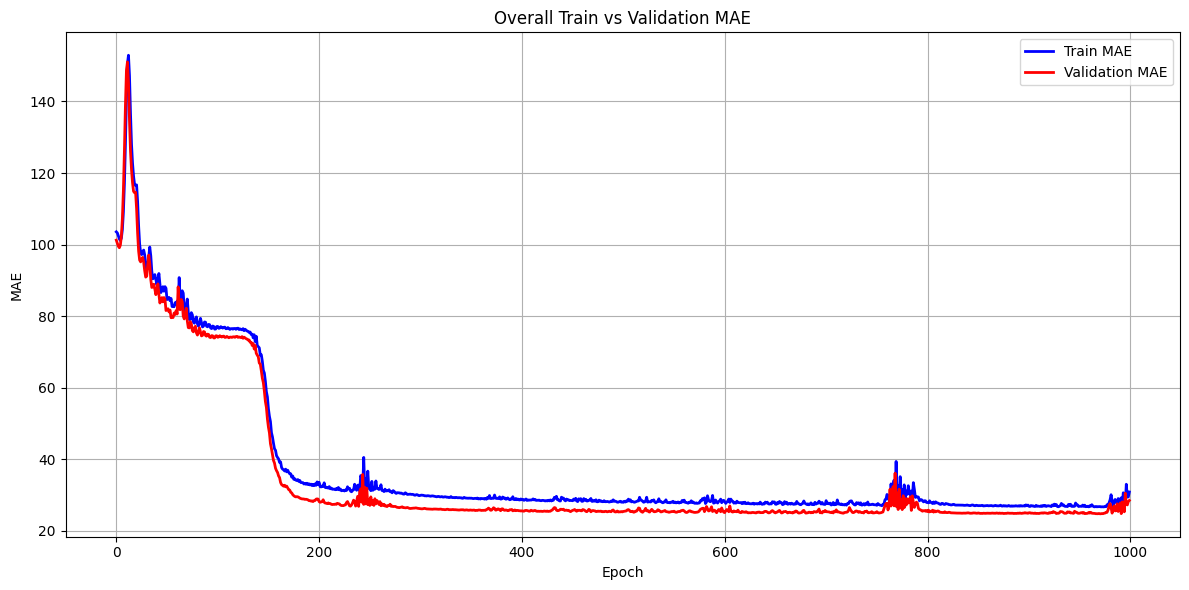

In [7]:
import matplotlib.pyplot as plt
import torch.optim as optim

# ===========================
#        SETTINGS
# ===========================
epochs = 1000

class Args:
    model_type = 'GraphSage'
    num_layers = 2 # k-hop neighborhood (k=2 seems to be the best...)
    hidden_dim = 256
    dropout = 0.1
args = Args()

target_dim  = data.y.size(1)
encoder_out_emb_dim = 91 # needs to match the total attribute dimension
model = GNNStack(numeric_attr_dim=numeric_attr, categories_list=categories, encoder_out_emb_dim=encoder_out_emb_dim,
                 hidden_dim=args.hidden_dim, output_dim=target_dim, args=args).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-3)
data = data.to(device)

best_val_loss = float('inf')
best_model = None

train_losses, val_losses = [], []
train_loss_hist = []
val_loss_hist = []

def mae(pred, target):
    return torch.mean(torch.abs(pred - target)).item()

def masked_mae(pred, true, mask):
    if mask.sum() == 0:
        return float('nan')
    return torch.mean(torch.abs(pred[mask] - true[mask])).item()


# ===== Training loop =====
for epoch in range(epochs):

    # ---------- TRAIN ----------
    model.train()
    optimizer.zero_grad()

    out = model(
        data.numeric, cat_list, categories,
        data.edge_index, data.batch
    )

    loss = model.loss(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()

    train_loss_hist.append(loss.item())

    # ---------- VALID ----------
    model.eval()
    with torch.no_grad():
        val_out = model(
            data.numeric, cat_list, categories,
            data.edge_index, data.batch
        )
        val_loss = model.loss(val_out[val_idx], data.y[val_idx])

    val_loss_hist.append(val_loss.item())

    # ---------- overall MAE ----------
    train_losses.append(mae(out[train_idx], data.y[train_idx]))
    val_losses.append(mae(val_out[val_idx], data.y[val_idx]))

    # ---------- save best ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    print(
        f"Epoch {epoch:03d} | "
        f"Train loss: {train_loss_hist[-1]:.4f} | "
        f"Val loss: {val_loss_hist[-1]:.4f} | "
        f"Train MAE: {train_losses[-1]:.2f} | "
        f"Val MAE: {val_losses[-1]:.2f}"
    )

# ===========================
#           TEST
# ===========================
best_model.eval()
with torch.no_grad():
    y_test = data.y[test_idx]
    y_pred_test = best_model(
        data.numeric, cat_list, categories,
        data.edge_index, data.batch
    )[test_idx]
    test_mae = mae(y_pred_test, y_test)
    print(f"Test MAE: {test_mae:.2f}")
    
# Printout
def report_feature_buckets(true, pred, feature, name):

    q20 = torch.quantile(feature, 0.2)
    q80 = torch.quantile(feature, 0.8)
    q90 = torch.quantile(feature, 0.9)

    buckets = {
        "Low": {
            "mask": feature <= q20,
            "range": (feature.min(), q20)
        },
        "Mid": {
            "mask": (feature > q20) & (feature < q80),
            "range": (q20, q80)
        },
        "High": {
            "mask": (feature >= q80) & (feature < q90),
            "range": (q80, q90)
        },
        "Very High": {
            "mask": feature >= q90,
            "range": (q90, feature.max())
        }
    }

    print(f"\nTEST — {name}")
    print(
        f"Overall MAE: "
        f"{torch.mean(torch.abs(pred - true)).item():.2f}"
    )

    for k, info in buckets.items():
        m = info["mask"]
        lo, hi = info["range"]

        bucket_mae = (
            torch.mean(torch.abs(pred[m] - true[m])).item()
            if m.sum() > 0 else float("nan")
        )

        print(
            f"{k:9s}[{lo:.0f}, {hi:.0f}]: "
            f"MAE = {bucket_mae:.2f} | "
            f"count = {m.sum().item()}"
        )

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train MAE", color="blue", lw=2)
plt.plot(val_losses, label="Validation MAE", color="red", lw=2)
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Overall Train vs Validation MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Save the model and datasplit.

In [11]:
MODEL_PT = "best_model.pt"
SPLIT_PT = "data_split.pt"
OUT_GPKG = "forest_predictions.gpkg"
CRS = "EPSG:3794"  # Slovenia D96/TM

torch.save(best_model.state_dict(), MODEL_PT)
torch.save(
    {"train_idx": train_idx, "val_idx": val_idx, "test_idx": test_idx},
    SPLIT_PT
)
nodes_with_region[["id"]].to_csv("node_index_map.csv", index=False)

print("Models are saved.")

Models are saved.


If you want to create a map of the models predictions in QGIS, run the following block.

In [36]:
split = torch.load(SPLIT_PT)
train_idx = split["train_idx"]
val_idx   = split["val_idx"]
test_idx  = split["test_idx"]

class Args:
    model_type = "GraphSage"
    num_layers = 2
    hidden_dim = 256
    dropout = 0.1

args = Args()

model = GNNStack(
    numeric_attr_dim=numeric_attr,
    categories_list=categories,
    encoder_out_emb_dim=91,
    hidden_dim=args.hidden_dim,
    output_dim=data.y.size(1),
    args=args
).to(device)

model.load_state_dict(torch.load(MODEL_PT, map_location=device))
model.eval()

with torch.no_grad():
    y_pred = model(
        data.numeric,
        cat_list,
        categories,
        data.edge_index,
        data.batch
    ).cpu()

print("y_pred shape:", y_pred.shape)
df = nodes_with_region.copy()

df["pred_etigl"] = y_pred[:, 0].round().numpy().astype(int)
df["pred_etlst"] = y_pred[:, 1].round().numpy().astype(int)

df["err_etigl"] = df["pred_etigl"] - df["etigl"]
df["err_etlst"] = df["pred_etlst"] - df["etlst"]

df["split"] = ""
df.loc[train_idx, "split"] = "train"
df.loc[val_idx,   "split"] = "val"
df.loc[test_idx,  "split"] = "test"

df_out = df[[
    "node_id",
    "etigl", "etlst",           # TRUE VALUES
    "pred_etigl", "pred_etlst", # MODEL PREDICTIONS
    "err_etigl", "err_etlst",   # ERRORS
    "split"
]]

df_out.to_csv("forest_predictions.csv", index=False)

print("forest_predictions.csv written")
print(df_out.head(10))
#print(df_out["err_etigl"].max())


y_pred shape: torch.Size([347338, 2])
forest_predictions.csv written
          node_id  etigl  etlst  pred_etigl  pred_etlst  err_etigl  err_etlst  \
0  01_01001A_A212      0      0           0           0          0          0   
1  01_01001A_A213      0      0          19           0         19          0   
2  01_01001A_A214      0      0           0           0          0          0   
3  01_01001B_A212      0      0          23           0         23          0   
4  01_01001B_A213      0      0           0           0          0          0   
5  01_01001C_A212      0      0           0           0          0          0   
6  01_01001C_A218      0      0           0           0          0          0   
7  01_01002A_A212      0      0           0           0          0          0   
8  01_01002A_A218      0      0           0           0          0          0   
9  01_01002B_A212      0      0          17           0         17          0   

   split  
0  train  
1    val  
2  tra

Final TEST result for conifer(iglavci) and deciduous(listavci) trees: 

In [39]:
lzigl_test = data.numeric[test_idx, 2]
report_feature_buckets(
    true = y_test[:, 0],
    pred = y_pred_test[:, 0],
    feature = lzigl_test,
    name = "etigl | bucketed by lzigl"
)
lzlst_test = data.numeric[test_idx, 3]
report_feature_buckets(
    true = y_test[:, 1],  
    pred = y_pred_test[:, 1],
    feature = lzlst_test,
    name = "etlst | bucketed by lzlst"
)


TEST — etigl | bucketed by lzigl
Overall MAE: 22.08
Low      [0, 0]: MAE = 0.68 | count = 9778
Mid      [0, 550]: MAE = 11.00 | count = 18007
High     [550, 1246]: MAE = 45.59 | count = 3470
Very High[1246, 27020]: MAE = 116.14 | count = 3479

TEST — etlst | bucketed by lzlst
Overall MAE: 28.48
Low      [0, 13]: MAE = 0.30 | count = 7011
Mid      [13, 806]: MAE = 15.63 | count = 20770
High     [806, 1545]: MAE = 56.29 | count = 3479
Very High[1545, 38972]: MAE = 134.33 | count = 3474


Final node embedding size:

In [40]:
print("Categories: ", categories)
print("Categorical embedding sizes per attribute:")
for i, mlp in enumerate(model.attribute_encoder.category_encoder.embedders):
    emb_dim = mlp[0].out_features
    print(f"Attribute {i}: {emb_dim} dims")

# To see the output shape of the encoder in isolation:
with torch.no_grad():
    temp_x = model.attribute_encoder(data.numeric, cat_list, categories)
    print("Output embedding shape:", temp_x.shape)

Categories:  [11, 21, 5, 6, 5, 5, 4, 5, 6, 39, 9, 4, 4, 9]
Categorical embedding sizes per attribute:
Attribute 0: 5 dims
Attribute 1: 10 dims
Attribute 2: 2 dims
Attribute 3: 3 dims
Attribute 4: 2 dims
Attribute 5: 2 dims
Attribute 6: 2 dims
Attribute 7: 2 dims
Attribute 8: 3 dims
Attribute 9: 19 dims
Attribute 10: 4 dims
Attribute 11: 2 dims
Attribute 12: 2 dims
Attribute 13: 4 dims
Output embedding shape: torch.Size([347338, 91])


Print some predictions:

In [41]:
import numpy as np

best_model.eval()

with torch.no_grad():
    all_predictions = best_model(data.numeric, cat_list, categories, data.edge_index, data.batch)

predictions_np = all_predictions.cpu().numpy()
true_labels_np = data.y.cpu().numpy()
attributes = data.numeric.cpu().numpy()

num_samples_to_show = 50
random_test_indices = np.random.choice(test_idx.cpu().numpy(), num_samples_to_show, replace=False)

print(f"Displaying predictions for {num_samples_to_show} random nodes from the test set:\n")

for i, idx in enumerate(random_test_indices):
    current_zaloga_igl = attributes[idx, val_cols.index('lzigl')]
    current_zaloga_lst = attributes[idx, val_cols.index('lzlst')]
    lzigl = true_labels_np[idx, 0]
    lzlst = true_labels_np[idx, 1]
    pred_etigl = round(predictions_np[idx, 0])
    pred_etlst = round(predictions_np[idx, 1])

    print(f"Node {idx + 1} (Test Sample {i + 1}):")
    print(f"  Current zaloga igl: {current_zaloga_igl:.2f}")
    print(f"  True etigl: {lzigl:.2f}, Predicted etigl: {pred_etigl:.2f}, Diff: {abs(lzigl - pred_etigl):.2f}")
    print(f"  Current zaloga lst: {current_zaloga_lst:.2f}")
    print(f"  True etlst: {lzlst:.2f}, Predicted etlst: {pred_etlst:.2f}, Diff: {abs(lzlst - pred_etlst):.2f}")
    print("--------------------------------------------------")


Displaying predictions for 50 random nodes from the test set:

Node 10337 (Test Sample 1):
  Current zaloga igl: 3.00
  True etigl: 0.00, Predicted etigl: 0.00, Diff: 0.00
  Current zaloga lst: 183.00
  True etlst: 27.00, Predicted etlst: 12.00, Diff: 15.00
--------------------------------------------------
Node 156910 (Test Sample 2):
  Current zaloga igl: 0.00
  True etigl: 0.00, Predicted etigl: 0.00, Diff: 0.00
  Current zaloga lst: 0.00
  True etlst: 0.00, Predicted etlst: 0.00, Diff: 0.00
--------------------------------------------------
Node 230972 (Test Sample 3):
  Current zaloga igl: 261.00
  True etigl: 52.00, Predicted etigl: 54.00, Diff: 2.00
  Current zaloga lst: 16.00
  True etlst: 3.00, Predicted etlst: 0.00, Diff: 3.00
--------------------------------------------------
Node 21205 (Test Sample 4):
  Current zaloga igl: 0.00
  True etigl: 0.00, Predicted etigl: 0.00, Diff: 0.00
  Current zaloga lst: 43.00
  True etlst: 11.00, Predicted etlst: 0.00, Diff: 11.00
---------

Graph visualizations:

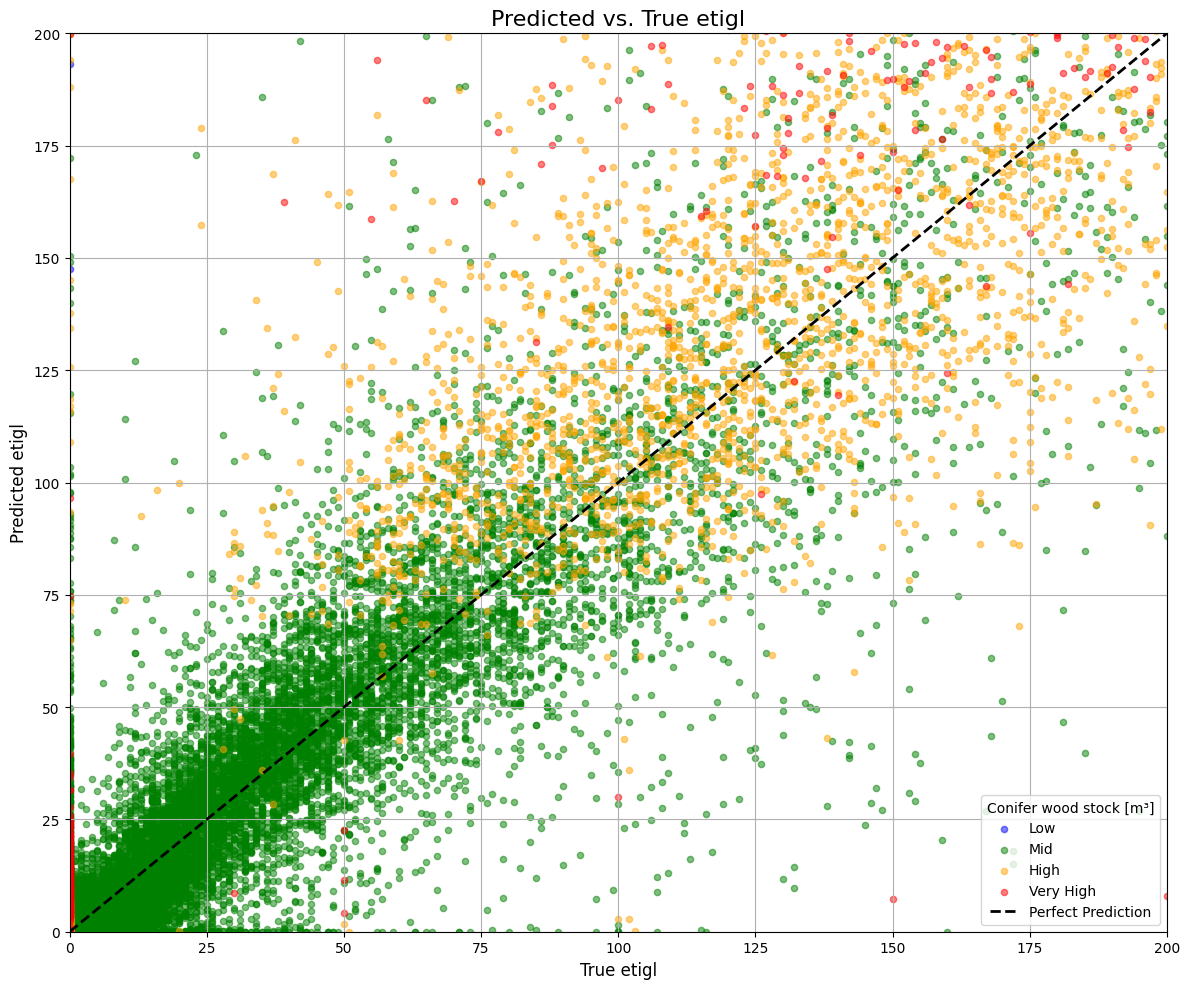


% of etigl predictions within ±10 per bucket:
Low      [0, 0]:  98.82% | count = 9663/9778
Mid      [1, 549]:  69.47% | count = 12510/18007
High     [550, 1245]:  21.76% | count = 755/3470
Very High[1246, 27020]:   8.91% | count = 310/3479

% of etigl predictions within ±25 per bucket:
Low      [0, 0]:  99.96% | count = 9774/9778
Mid      [1, 549]:  89.17% | count = 16056/18007
High     [550, 1245]:  43.89% | count = 1523/3470
Very High[1246, 27020]:  21.67% | count = 754/3479

% of etigl predictions within ±100 per bucket:
Low      [0, 0]:  99.97% | count = 9775/9778
Mid      [1, 549]:  99.16% | count = 17856/18007
High     [550, 1245]:  90.37% | count = 3136/3470
Very High[1246, 27020]:  63.55% | count = 2211/3479


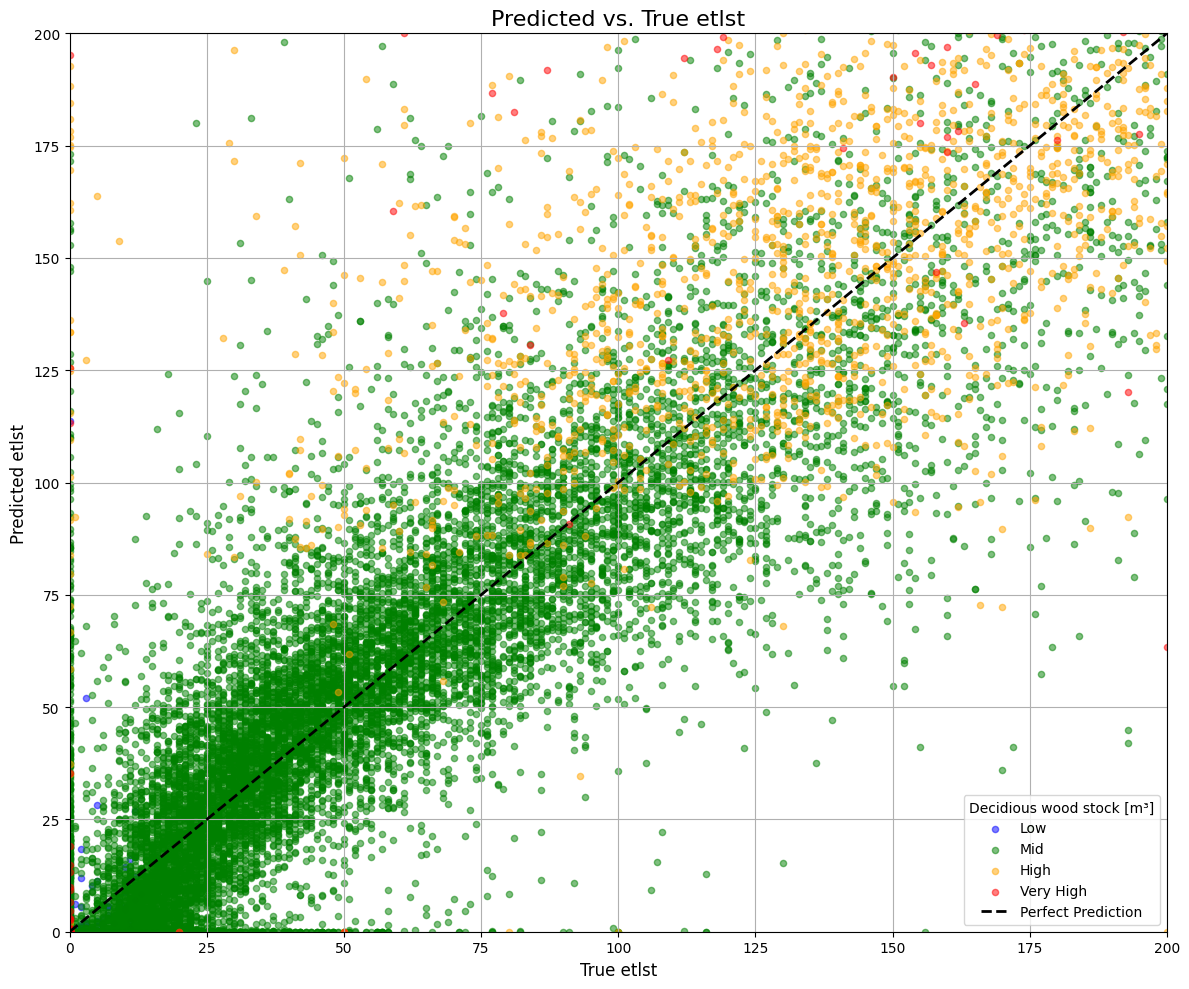


% of etlst predictions within ±10 per bucket:
Low      [0, 13]:  99.73% | count = 6992/7011
Mid      [14, 805]:  54.91% | count = 11405/20770
High     [806, 1544]:  18.22% | count = 634/3479
Very High[1545, 38972]:  11.80% | count = 410/3474

% of etlst predictions within ±25 per bucket:
Low      [0, 13]:  99.97% | count = 7009/7011
Mid      [14, 805]:  83.04% | count = 17247/20770
High     [806, 1544]:  38.72% | count = 1347/3479
Very High[1545, 38972]:  21.65% | count = 752/3474

% of etlst predictions within ±100 per bucket:
Low      [0, 13]:  99.99% | count = 7010/7011
Mid      [14, 805]:  98.63% | count = 20485/20770
High     [806, 1544]:  84.16% | count = 2928/3479
Very High[1545, 38972]:  58.00% | count = 2015/3474


In [47]:
import numpy as np

pred_etigl = y_pred_test[:, 0].cpu().numpy()
true_etigl = y_test[:, 0].cpu().numpy()
lzigl = data.numeric[test_idx, 2].cpu().numpy()

pred_etlst = y_pred_test[:, 1].cpu().numpy()
true_etlst = y_test[:, 1].cpu().numpy()
lzlst = data.numeric[test_idx, 3].cpu().numpy()


# --- Define buckets ---
def define_buckets(values):
    q20 = np.quantile(values, 0.2)
    q80 = np.quantile(values, 0.8)
    q90 = np.quantile(values, 0.9)
    buckets = {
        "Low":        values <= q20,
        "Mid":       (values > q20) & (values < q80),
        "High":      (values >= q80) & (values < q90),
        "Very High":  values >= q90
    }
    return buckets, (q20, q80, q90)

buckets_lzigl, _ = define_buckets(lzigl)
buckets_lzlst, _ = define_buckets(lzlst)

# --- Plot function (with ±X band only) ---
def plot_pred_vs_true(true, pred, buckets, target_name, bucket_name, xlim=(0,200), ylim=(0,200)):
    colors = {"Low": "blue", "Mid": "green", "High": "orange", "Very High": "red"}
    
    plt.figure(figsize=(12, 10))
    for k, mask in buckets.items():
        plt.scatter(true[mask], pred[mask], label=k, color=colors[k], alpha=0.5, s=20)

    # Perfect prediction line with ± band
    x_vals = np.linspace(xlim[0], xlim[1], 500)
    plt.plot(x_vals, x_vals, 'k--', lw=2, label='Perfect Prediction')
    #plt.plot(x_vals, x_vals + 20, color='gray', linestyle='--', lw=1)
    #plt.plot(x_vals, x_vals - 20, color='gray', linestyle='--', lw=1)
    #plt.fill_between(x_vals, x_vals - 20, x_vals + 20, color='gray', alpha=0.6)

    plt.title(f'Predicted vs. True {target_name}', fontsize=16)
    plt.xlabel(f'True {target_name}', fontsize=12)
    plt.ylabel(f'Predicted {target_name}', fontsize=12)
    plt.legend(title=f'{bucket_name}', loc='lower right')
    plt.grid(True)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.tight_layout()
    plt.show()


def bucket_calc(feature, mask):
    if mask.sum() > 0:
        return feature[mask].min(), feature[mask].max()
    else:
        return None, None



# --- Function to print % of points within a band, including range ---
def print_within_band(true, pred, feature, buckets, target_name, band):
    def pct_within_band(true, pred, mask, band):
        if mask.sum() == 0:
            return float('nan')
        return 100.0 * (np.abs(pred[mask] - true[mask]) <= band).mean()

    print(f"\n% of {target_name} predictions within ±{band} per bucket:")
    for k, mask in buckets.items():
        pct = pct_within_band(true, pred, mask, band)
        bucket_range = bucket_calc(feature,mask)
        print(f"{k:9s}[{bucket_range[0]:.0f}, {bucket_range[1]:.0f}]: {pct:6.2f}% | count = {(pct*mask.sum()/100):.0f}/{mask.sum()}")

# --- Plot & print for etigl ---
plot_pred_vs_true(true_etigl, pred_etigl, buckets_lzigl, "etigl", "Conifer wood stock [m³]")
print_within_band(true_etigl, pred_etigl, lzigl, buckets_lzigl, "etigl", 10)
print_within_band(true_etigl, pred_etigl, lzigl, buckets_lzigl, "etigl", 25)
print_within_band(true_etigl, pred_etigl, lzigl, buckets_lzigl, "etigl", 100)

# --- Plot & print for etlst ---
plot_pred_vs_true(true_etlst, pred_etlst, buckets_lzlst, "etlst", "Decidious wood stock [m³]")
print_within_band(true_etlst, pred_etlst, lzlst, buckets_lzlst, "etlst", 10)
print_within_band(true_etlst, pred_etlst, lzlst, buckets_lzlst, "etlst", 25)
print_within_band(true_etlst, pred_etlst, lzlst, buckets_lzlst, "etlst", 100)


Prediction graph by stand density:

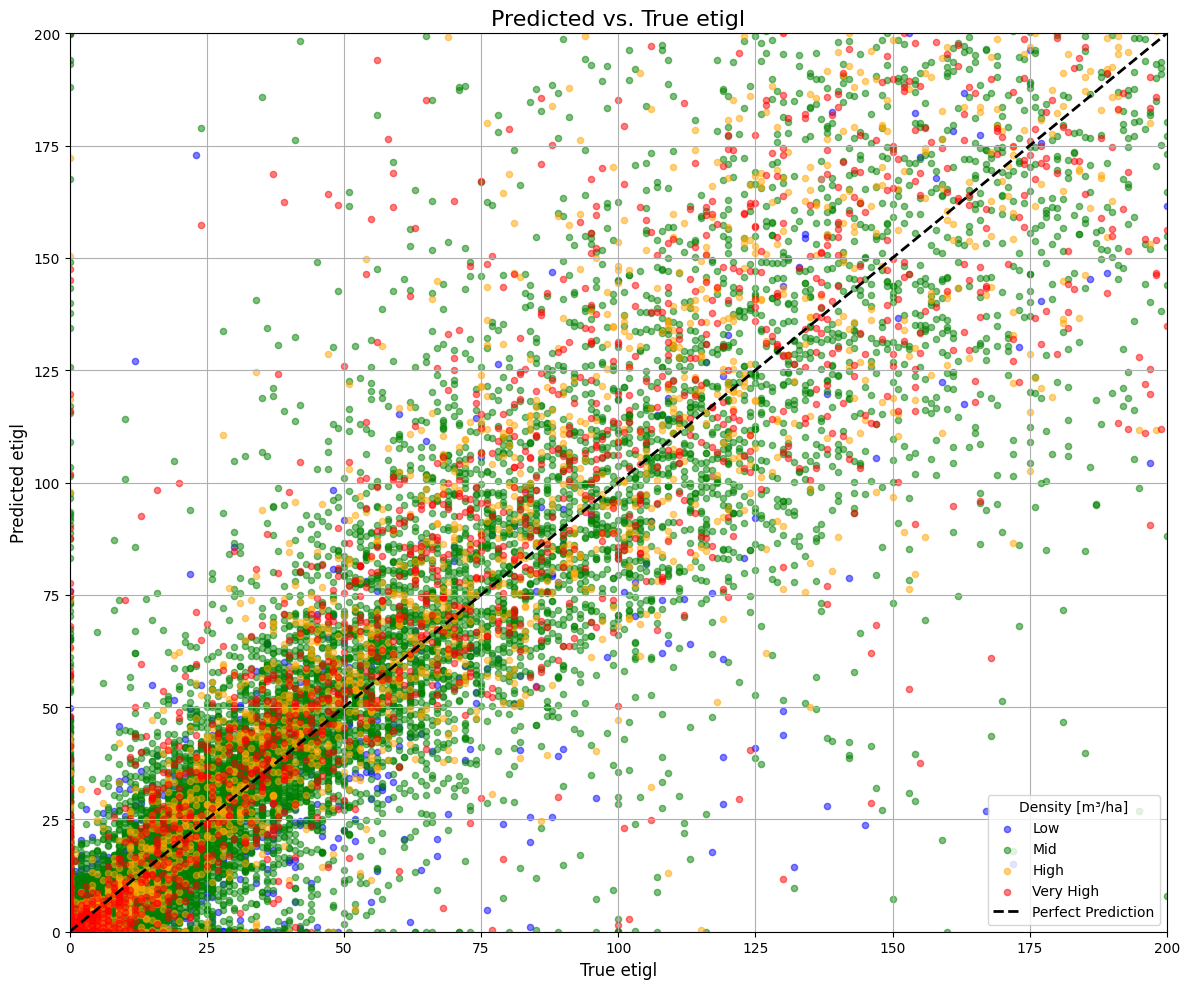


% of etigl predictions within ±10 per bucket:
Low      [0, 116]:  93.26% | count = 6480/6948
Mid      [116, 407]:  66.69% | count = 13897/20839
High     [407, 479]:  48.23% | count = 1675/3473
Very High[479, 10594]:  34.14% | count = 1186/3474

% of etigl predictions within ±25 per bucket:
Low      [0, 116]:  97.74% | count = 6791/6948
Mid      [116, 407]:  82.52% | count = 17197/20839
High     [407, 479]:  66.60% | count = 2313/3473
Very High[479, 10594]:  51.99% | count = 1806/3474

% of etigl predictions within ±100 per bucket:
Low      [0, 116]:  99.70% | count = 6927/6948
Mid      [116, 407]:  95.97% | count = 19999/20839
High     [407, 479]:  91.28% | count = 3170/3473
Very High[479, 10594]:  82.96% | count = 2882/3474


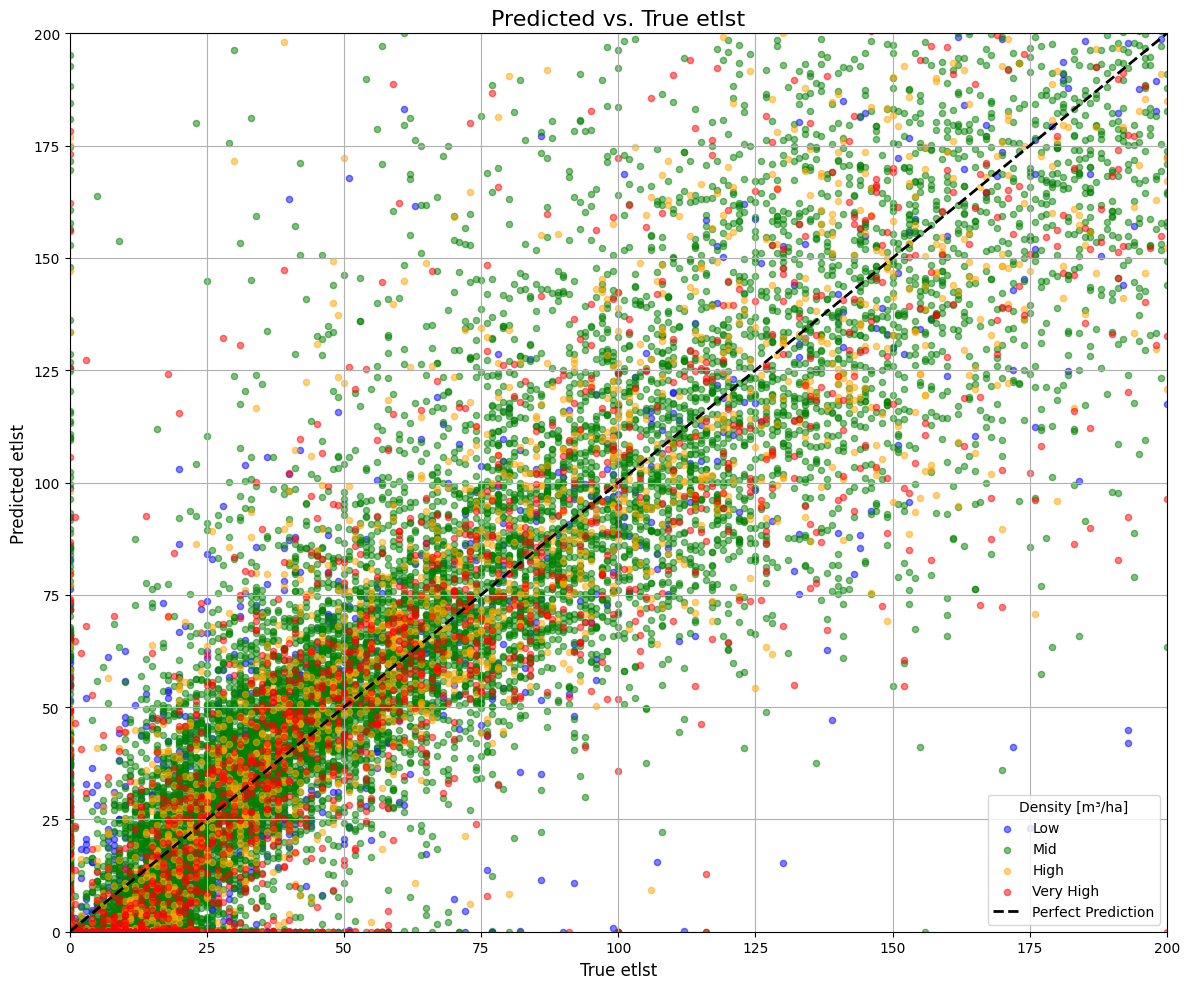


% of etlst predictions within ±10 per bucket:
Low      [0, 116]:  86.28% | count = 5995/6948
Mid      [116, 407]:  48.90% | count = 10190/20839
High     [407, 479]:  43.16% | count = 1499/3473
Very High[479, 10594]:  50.58% | count = 1757/3474

% of etlst predictions within ±25 per bucket:
Low      [0, 116]:  94.46% | count = 6563/6948
Mid      [116, 407]:  72.20% | count = 15045/20839
High     [407, 479]:  66.69% | count = 2316/3473
Very High[479, 10594]:  69.98% | count = 2431/3474

% of etlst predictions within ±100 per bucket:
Low      [0, 116]:  99.09% | count = 6885/6948
Mid      [116, 407]:  92.39% | count = 19253/20839
High     [407, 479]:  90.33% | count = 3137/3473
Very High[479, 10594]:  91.05% | count = 3163/3474


In [48]:
povrsina = data.numeric[test_idx, 0].cpu().numpy()
povrsina_safe = np.where(povrsina == 0, 0.1, povrsina)

lzigl = data.numeric[test_idx, 2].cpu().numpy()
lzlst = data.numeric[test_idx, 3].cpu().numpy()

density = (lzigl + lzlst) / povrsina_safe
buckets_density, _ = define_buckets(density)
# --- etigl bucketed by density ---
plot_pred_vs_true(true_etigl, pred_etigl, buckets_density, "etigl", "Density [m³/ha]")
print_within_band(true_etigl, pred_etigl, density, buckets_density, "etigl", 10)
print_within_band(true_etigl, pred_etigl, density, buckets_density, "etigl", 25)
print_within_band(true_etigl, pred_etigl, density, buckets_density, "etigl", 100)

# --- etlst bucketed by density ---
plot_pred_vs_true(true_etlst, pred_etlst, buckets_density, "etlst", "Density [m³/ha]")
print_within_band(true_etlst, pred_etlst, density, buckets_density, "etlst", 10)
print_within_band(true_etlst, pred_etlst, density, buckets_density, "etlst", 25)
print_within_band(true_etlst, pred_etlst, density, buckets_density, "etlst", 100)

In [44]:
print(type(nodes_with_region['GEOMETRY_x'].iloc[0]))
print(nodes_with_region['GEOMETRY_x'].head())


<class 'str'>
0    AQYAAAADAAAAAQMAAAABAAAAvwAAADGx+Rj8VBhBVPzfMS...
1    AQYAAAABAAAAAQMAAAABAAAAQAEAAKweMG9GXBhBz9iXLO...
2    AQYAAAABAAAAAQMAAAABAAAAXAAAAIKtEkwNXRhB2A3bVu...
3    AQYAAAAPAAAAAQMAAAABAAAAGgAAAIZ2ToMzUxhBbheay6...
4    AQYAAAABAAAAAQMAAAABAAAAHQAAAKweMG9GXBhBz9iXLO...
Name: GEOMETRY_x, dtype: object
